In [1]:
import pandas as pd
import configparser
import pymysql
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from matplotlib import cm
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.decomposition import PCA
import warnings; warnings.simplefilter('ignore')

In [2]:
parser = configparser.ConfigParser()
parser.read("config\mysql.conf")
hostname = parser.get("mysql_config", "hostname")
username = parser.get("mysql_config", "username")
password = parser.get("mysql_config", "password")
dbname = parser.get("mysql_config", "database")
port = parser.get("mysql_config", "port")

conn_str = 'mysql+pymysql://' + username + ':' + password + '@' + hostname + '/' + dbname
db_connection = create_engine(conn_str)

Zwyczajny algorytm k-means

In [3]:
ratings = pd.read_sql('SELECT * FROM movies_dwh.v_ml_ratings', con = db_connection)
ratings.drop(['rating_date', 'rating_time'], axis=1, inplace=True)

In [4]:
col = 'user_id'
counts = ratings.groupby(col).size().reset_index(name='count')
under_twenty = counts[counts['count'] < 20]
movies_to_delete = under_twenty[col].to_list()
all_movies = set(ratings[col].unique())
movies_to_delete_set = set(movies_to_delete)
movies_to_keep = all_movies - movies_to_delete_set
movies_to_keep_list = list(movies_to_keep)
movies_to_keep_df = pd.DataFrame(movies_to_keep_list, columns=[col])
final_ratings = pd.merge(movies_to_keep_df, ratings, how='left', on=col)

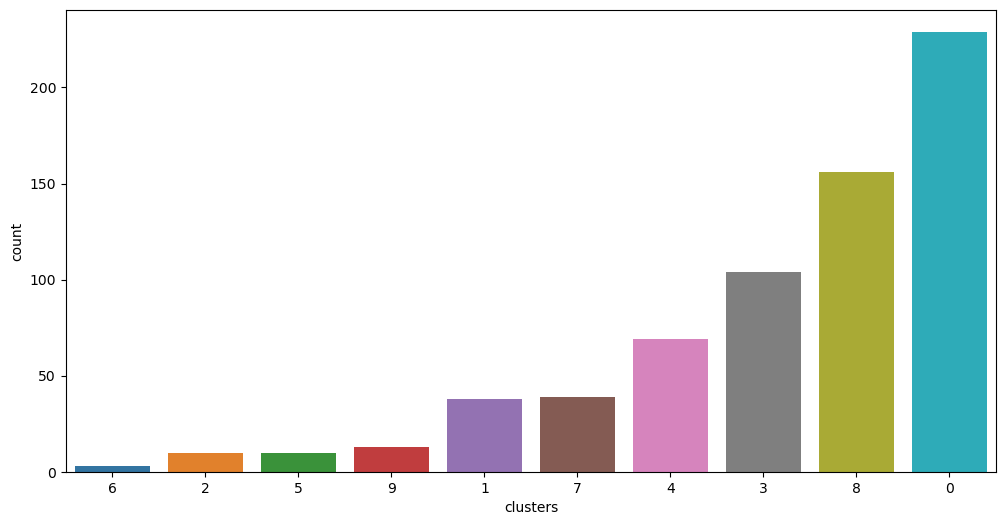

In [10]:
#ratings_matrix = final_ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix.fillna(0)
X = ratings_matrix.values

pca = PCA(n_components=1)
X = pca.fit_transform(X)

kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=0)
kmeans.fit(X)

clusters = kmeans.predict(X)
ratings_matrix['clusters'] = clusters

plt.figure(figsize=(12, 6))
ratings_grouped = ratings_matrix.groupby('clusters').size().reset_index(name='count')
sns.barplot(data=ratings_grouped, x='clusters', y='count', order=ratings_grouped.sort_values('count').clusters)
plt.show()

Ze standaryzacją

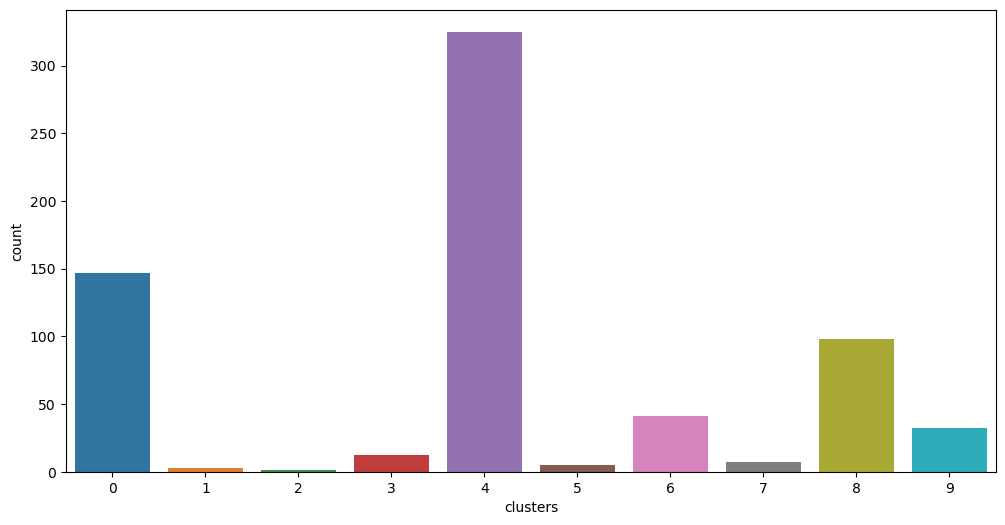

In [69]:
#ratings_matrix = final_ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix.fillna(0)

scaler = StandardScaler()
ratings_extr = ratings[['rating']]
ratings_others = ratings[['user_id', 'movie_id']]
scaled_data = scaler.fit_transform(ratings_extr)
scaled_data_df = pd.DataFrame(scaled_data, columns=['rating'])
scaled = pd.concat([ratings_others, scaled_data_df], axis=1)

ratings_matrix = scaled.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix.fillna(0)
X = ratings_matrix.values

pca = PCA(n_components=1)
X = pca.fit_transform(X)

kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=0)
kmeans.fit(X)

clusters = kmeans.predict(X)
ratings_matrix['clusters'] = clusters

plt.figure(figsize=(12, 6))
ratings_grouped = ratings_matrix.groupby('clusters').size().reset_index(name='count')
sns.barplot(ratings_grouped, x='clusters', y='count')
plt.show()

Z normalizacją

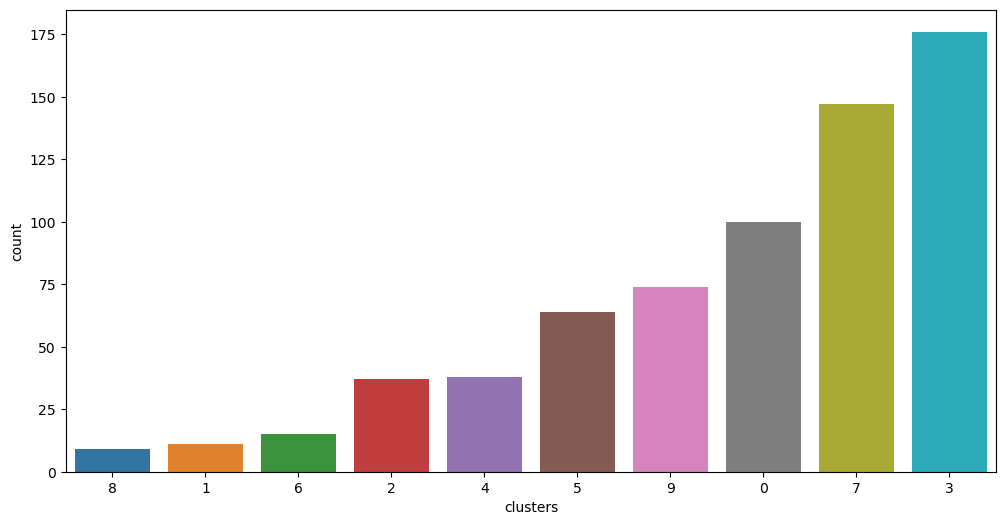

In [21]:
#ratings_matrix = final_ratings.pivot(index='user_id', columns='movie_id', values='rating')
def normalize_row(row):
    return row - row.mean()

ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix.fillna(0)
normalized_ratings = ratings_matrix.apply(normalize_row, axis=1)
X = normalized_ratings.values

pca = PCA(n_components=1)
X = pca.fit_transform(X)

kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=0)
kmeans.fit(X)

clusters = kmeans.predict(X)
ratings_matrix['clusters'] = clusters

plt.figure(figsize=(12, 6))
ratings_grouped = ratings_matrix.groupby('clusters').size().reset_index(name='count')
sns.barplot(ratings_grouped, x='clusters', y='count', order = ratings_grouped.sort_values('count').clusters)
plt.show()

1
2
3
4
5
6
7
8
9


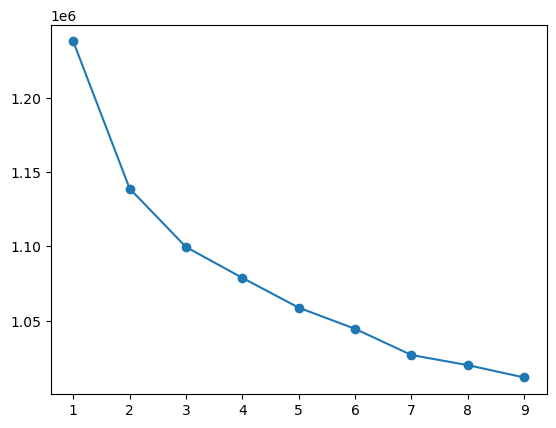

In [22]:
X = ratings_matrix.values
distortions = []
for i in range(1, 10):
    kmeans = KMeans(
        n_clusters=i,
        init='k-means++',
        random_state=0
    )
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    print(i)
plt.plot(range(1, 10), distortions, marker='o')
plt.show()

In [17]:
X

array([[-1.06419258e+01],
       [-5.20653818e+00],
       [-5.59142693e+00],
       [ 1.58086716e+01],
       [ 1.11326430e+00],
       [-7.15934279e+00],
       [-7.76021035e-01],
       [ 7.14964134e+00],
       [-5.78248989e+00],
       [-6.21496503e+00],
       [-9.70499506e+00],
       [-9.23615279e+00],
       [-5.16328733e+00],
       [-1.00714317e+01],
       [ 5.22713084e+01],
       [-7.73032523e+00],
       [ 1.73016561e+01],
       [-9.61699805e+00],
       [ 2.29103884e+01],
       [-3.16039110e+00],
       [ 7.15594495e+00],
       [ 1.07619307e+01],
       [ 4.24097949e+01],
       [-9.44750932e+00],
       [-9.77727477e+00],
       [ 3.39275026e+00],
       [-7.80594119e+00],
       [-4.97272472e+00],
       [-1.06480135e+01],
       [ 5.34976168e+01],
       [-1.67858346e+00],
       [-7.23443168e+00],
       [-4.08492880e+00],
       [ 1.16268464e+01],
       [-1.09931993e+01],
       [-4.59416264e+00],
       [-7.32149119e+00],
       [-2.53244240e+00],
       [-7.1

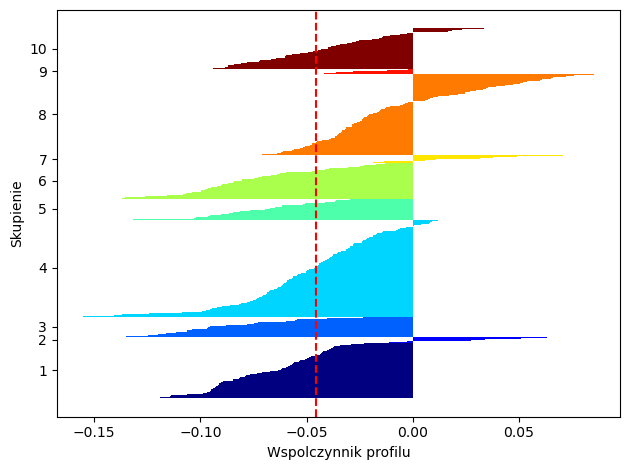

In [23]:
cluster_labels = np.unique(clusters)
n_clusters = kmeans.n_clusters
silhouette_vals = silhouette_samples(X, clusters, metric='cosine')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[clusters == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height = 1.0,
            edgecolor = 'none',
            color=color)
    yticks.append((y_ax_lower + y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Skupienie')
plt.xlabel('Wspolczynnik profilu')
plt.tight_layout()
plt.show()

In [64]:
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix.fillna(0)
X = ratings_matrix.values
pca = PCA(n_components=1)
X = pca.fit_transform(X)

# Funkcja do oceny RMSE dla danego zestawu parametrów
def evaluate_kmeans():
    kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=0)
    clusters = kmeans.fit_predict(X)

    # Dodanie klastrów do macierzy ocen
    ratings_matrix['clusters'] = clusters
    cluster_ratings = ratings_matrix.groupby('clusters').mean()

    # Ignorowanie szumu (cluster = -1)
    #non_noise_clusters = cluster_ratings.drop(-1, errors='ignore')

    # Funkcja do przewidywania ocen
    def predict_rating(row):
        cluster_id = row['clusters']
        if cluster_id == -1:
            return np.nan  # Ignorowanie szumu
        return cluster_ratings.loc[cluster_id]

    # Przewidywanie ocen na podstawie klastrów
    predicted_ratings = ratings_matrix.apply(predict_rating, axis=1).fillna(0)

    # Usuwanie kolumny cluster przed obliczeniem RMSE
    original_ratings = ratings_matrix.drop(columns=['clusters'])

    # Obliczanie RMSE
    rmse = sqrt(mean_squared_error(original_ratings.values, predicted_ratings.values))
    return rmse

rmse = evaluate_kmeans()
rmse

0.41325014486622863

Zwyczajny algorytm DBSCAN

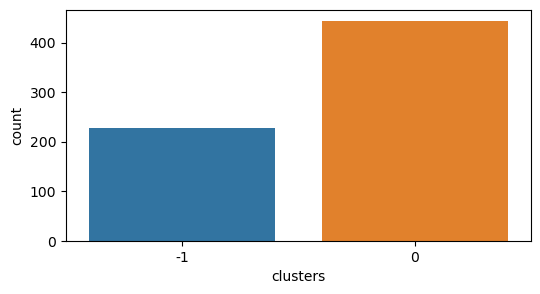

In [59]:
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix.fillna(0)
X = ratings_matrix.values
db = DBSCAN(eps=0.7, min_samples=10, metric='cosine')
y_db = db.fit_predict(X)
ratings_matrix['clusters'] = y_db

plt.figure(figsize=(6, 3))
ratings_grouped = ratings_matrix.groupby('clusters').size().reset_index(name='count')
sns.barplot(ratings_grouped, x='clusters', y='count')
plt.show()

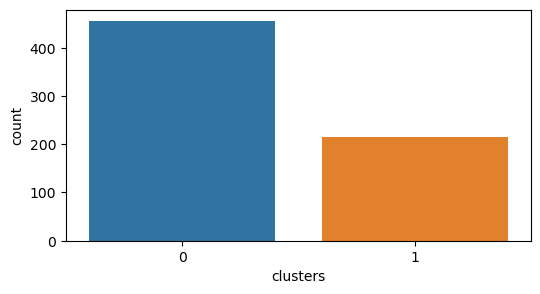

In [4]:
def normalize_row(row):
    return row - row.mean()

ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix.fillna(0)
normalized_ratings = ratings_matrix.apply(normalize_row, axis=1)
X = normalized_ratings.values

#ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
#ratings_matrix = ratings_matrix.fillna(0)
#X = ratings_matrix.values
pca = PCA(n_components=1)
X = pca.fit_transform(X)
db = DBSCAN(eps=0.6, min_samples=5, metric='cosine')
y_db = db.fit_predict(X)
ratings_matrix['clusters'] = y_db

plt.figure(figsize=(6, 3))
ratings_grouped = ratings_matrix.groupby('clusters').size().reset_index(name='count')
sns.barplot(ratings_grouped, x='clusters', y='count')
plt.show()

In [42]:
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix.fillna(0)
X = ratings_matrix.values
pca = PCA(n_components=1)
X = pca.fit_transform(X)
eps = np.arange(0.5, 1, 0.05).tolist()
samples = [3, 4, 5, 6, 7]
metrics = ['cosine', 'jaccard']
for metric in metrics:
    for sample in samples:
        for i in eps:
            clusters = ratings_matrix
            db = DBSCAN(eps=i, min_samples=sample, metric=metric)
            y_db = db.fit_predict(X)
            clusters['clusters'] = y_db
            clusters_grouped = clusters.groupby('clusters').size().reset_index(name='count')
            if clusters_grouped.size != 2:
                print(metric)
                print(sample)
                print(i)
                print(clusters_grouped)
                print('-' * 20)

cosine
3
0.5
   clusters  count
0         0    465
1         1    206
--------------------
cosine
3
0.55
   clusters  count
0         0    465
1         1    206
--------------------
cosine
3
0.6000000000000001
   clusters  count
0         0    465
1         1    206
--------------------
cosine
3
0.6500000000000001
   clusters  count
0         0    465
1         1    206
--------------------
cosine
3
0.7000000000000002
   clusters  count
0         0    465
1         1    206
--------------------
cosine
3
0.7500000000000002
   clusters  count
0         0    465
1         1    206
--------------------
cosine
3
0.8000000000000003
   clusters  count
0         0    465
1         1    206
--------------------
cosine
3
0.8500000000000003
   clusters  count
0         0    465
1         1    206
--------------------
cosine
3
0.9000000000000004
   clusters  count
0         0    465
1         1    206
--------------------
cosine
3
0.9500000000000004
   clusters  count
0         0    465
1        

In [27]:
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
ratings_matrix = ratings_matrix.fillna(0)
X = ratings_matrix.values
pca = PCA(n_components=1)
X = pca.fit_transform(X)

# Funkcja do oceny RMSE dla danego zestawu parametrów
def evaluate_dbscan(eps, min_samples, metric):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    clusters = db.fit_predict(X)

    # Dodanie klastrów do macierzy ocen
    ratings_matrix['clusters'] = clusters
    cluster_ratings = ratings_matrix.groupby('clusters').mean()

    # Ignorowanie szumu (cluster = -1)
    non_noise_clusters = cluster_ratings.drop(-1, errors='ignore')

    # Funkcja do przewidywania ocen
    def predict_rating(row):
        cluster_id = row['clusters']
        if cluster_id == -1:
            return np.nan  # Ignorowanie szumu
        return non_noise_clusters.loc[cluster_id]

    # Przewidywanie ocen na podstawie klastrów
    predicted_ratings = ratings_matrix.apply(predict_rating, axis=1).fillna(0)

    # Usuwanie kolumny cluster przed obliczeniem RMSE
    original_ratings = ratings_matrix.drop(columns=['clusters'])

    # Obliczanie RMSE
    rmse = sqrt(mean_squared_error(original_ratings.values, predicted_ratings.values))
    return rmse

# Szukanie optymalnych parametrów
best_eps = None
best_min_samples = None
best_metric = None
best_rmse = float('inf')

eps_values = np.arange(0.6, 1, 0.05)
min_samples_values = range(5, 10)
metrics = ['jaccard', 'cosine']

for metric in metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                rmse = evaluate_dbscan(eps, min_samples, metric)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_eps = eps
                    best_min_samples = min_samples
                    best_metric = metric
            except Exception as e:
                # Obsługa błędów, jeśli klastrowanie nie powiedzie się
                print(f"Błąd dla metric={metric}, eps={eps}, min_samples={min_samples}: {e}")

print(f"Najlepsze eps: {best_eps}")
print(f"Najlepsze min_samples: {best_min_samples}")
print(f"Najlepsze metric: {best_metric}")
print(f"Najlepsze RMSE: {best_rmse}")

Najlepsze eps: 0.6
Najlepsze min_samples: 5
Najlepsze metric: cosine
Najlepsze RMSE: 0.43461410176409854


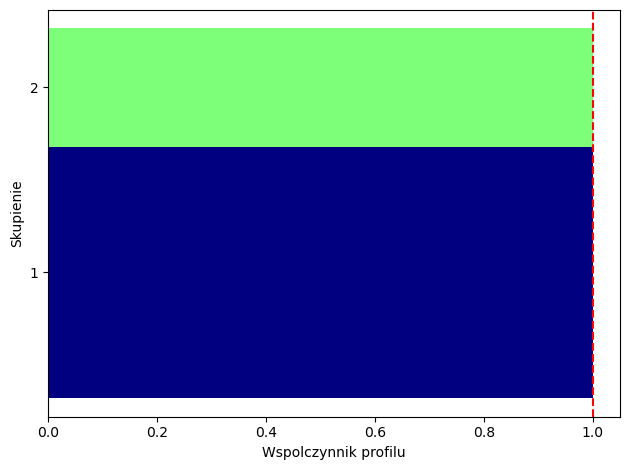

In [5]:
cluster_labels = np.unique(y_db)
n_clusters = 2
silhouette_vals = silhouette_samples(X, y_db, metric='cosine')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_db == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height = 1.0,
            edgecolor = 'none',
            color=color)
    yticks.append((y_ax_lower + y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Skupienie')
plt.xlabel('Wspolczynnik profilu')
plt.tight_layout()
plt.show()